# Index
1. <a href="#data_loading">Data Loading</a>
2. [Insights](#insights)
3. [Pretrained model](#pretrained)
4. [Customized CNN](#customized_model)
5. [Data Augmentation](#data_augmentation)
6. [Grid Search](#grid_search)

In [21]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import shap


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

AUTOTUNE = tf.data.experimental.AUTOTUNE

<a id="data_loading"></a>

## Loading and preprocessing data

---

In [22]:
def convertToFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [23]:
def getImages(row):
    return row[0]

def getNumpyArray(tf_dataset):
    X = list(tf_dataset)
    X = np.concatenate(list(map(getImages,X)))
    return X

In [24]:
def getLabel(row):
    return row[1]

def getLabels(tf_dataset):
    y = list(tf_dataset)
    y = np.concatenate(list(map(getLabel,y)))
    return y

In [25]:
image_size = (48, 48)
# Load training, validation and test sets
ds_train = image_dataset_from_directory(
    'dataset/train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=image_size,
    batch_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val = image_dataset_from_directory(
    'dataset/train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=image_size,
    batch_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test = image_dataset_from_directory(
    'dataset/test',
    image_size=image_size,
    batch_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)

class_names = np.array(ds_train.class_names)

ds_train = (
    ds_train
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val = (
    ds_val
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# X_train = getNumpyArray(ds_train)
# y_train = getLabels(ds_train)

# normalizer = preprocessing.Normalization(axis=1)
# normalizer.adapt(ds_train,batch_size=128)
# ds_train = normalizer(ds_train)
# ds_val = normalizer(ds_val)
# ds_test = normalizer(ds_test)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [26]:
# to use the pretrained model
image_size = (224, 224)
# Load training, validation and test sets
ds_train_224 = image_dataset_from_directory(
    'dataset/train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_224 = image_dataset_from_directory(
    'dataset/train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_224 = image_dataset_from_directory(
    'dataset/test',
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train_224 = (
    ds_train_224
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val_224 = (
    ds_val_224
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test_224 = (
    ds_test_224
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalizer_224 = preprocessing.Normalization()
# normalizer_224.adapt(ds_train_224)
# ds_train_224 = normalizer(ds_train_224)
# ds_val_224 = normalizer(ds_val_224)
# ds_test_224 = normalizer(ds_test_224)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


<a id="insights"></a>

# Getting insights

---

In [27]:
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [28]:
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

y_train_224 = getLabels(ds_train_224)
y_val_224 = getLabels(ds_val_224)
y_test_224 = getLabels(ds_test_224)

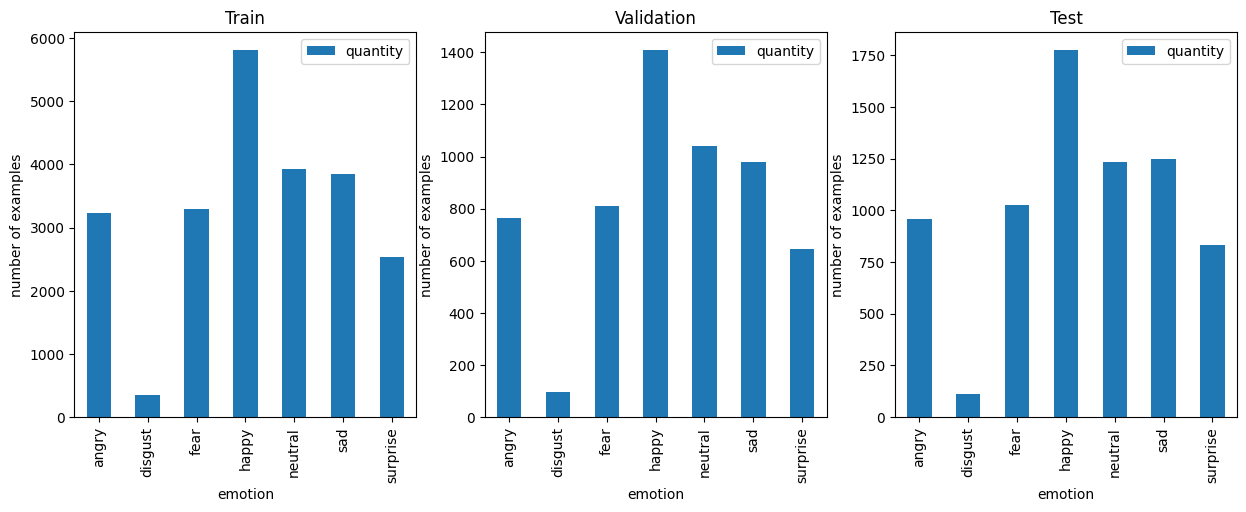

In [29]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train], 'quantity': np.ones(y_train.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val], 'quantity': np.ones(y_val.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test], 'quantity': np.ones(y_test.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

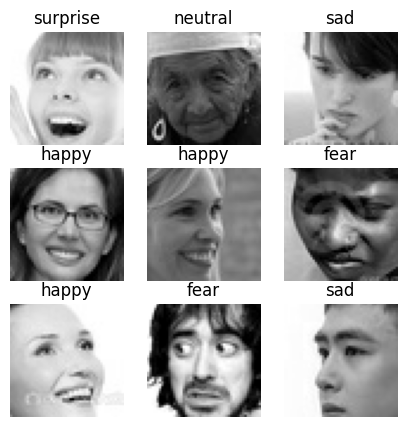

In [30]:
X_train = getNumpyArray(ds_train)
plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i]])
  plt.axis("off");

<a id="pretrained"></a>

# Pretrained model

---

In [31]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              1529968   
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________


In [32]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=30,
# )
# model.save('models/my_model.h5')
# with open('models/history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [33]:
model = load_model('models/my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [34]:
def evaluate(model,history,ds_train,ds_val,ds_test,y_train,y_val,y_test):
    f,axes = plt.subplots(1,2,figsize=(20,5))
    history_frame = pd.DataFrame(history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

    print("Calculating training results:")
    y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
    print("Calculating validation results:")
    y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
    print("Calculating test results:")
    y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

    f, axes= plt.subplots(1,3,figsize=(20,5))
    accuracies = []
    accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
    mat = confusion_matrix(y_train, y_train_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

    accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
    mat = confusion_matrix(y_val, y_val_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

    accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
    mat = confusion_matrix(y_test,y_test_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

    for i in range(3):
        axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
        axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
        axes[i].xaxis.set_ticklabels(class_names); axes[i].yaxis.set_ticklabels(class_names);

Calculating training results:


2023-04-23 14:38:03.246932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 36s 50ms/step
Calculating validation results:
180/180 [==============================] - 9s 51ms/step
Calculating test results:
225/225 [==============================] - 11s 51ms/step


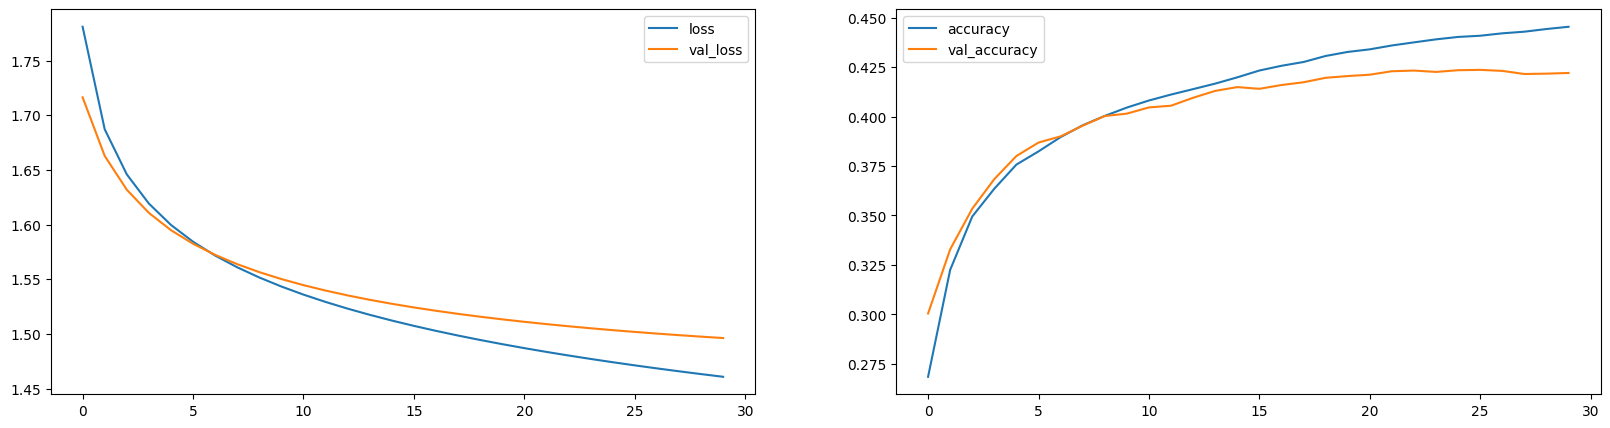

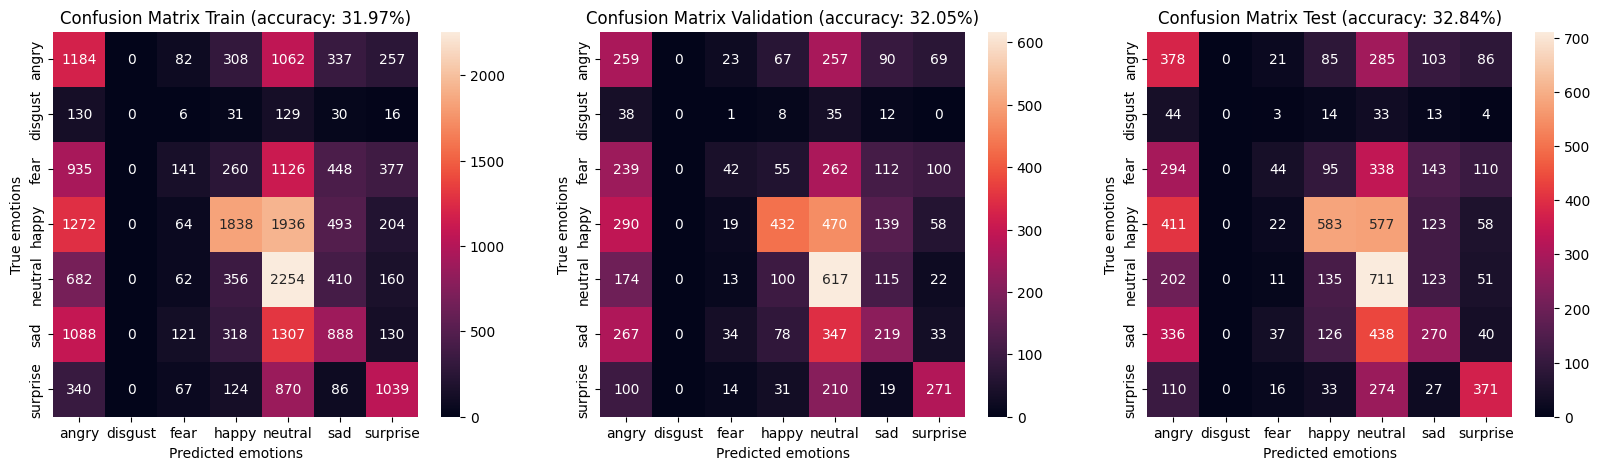

In [35]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224,y_train_224,y_val_224,y_test_224)

There are very few "disgust" examples so they're the most difficult ones to predict, on the other hand "happy" is widely represented so it predicts them very well

<a id="customized_model"></a>

# Customized CNN

---

In [36]:
def createModel():
    tf.random.set_seed(1)
    model= tf.keras.models.Sequential([
        preprocessing.Normalization(),

        Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(64,(3,3), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128,(5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
            
        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),
            
        Dense(512,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(7, activation='softmax')
    ])
    model.build([None, 48, 48, 3])
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [37]:
model= createModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 48, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

In [38]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('models/my_model_custom.h5')
# with open('models/history_custom.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [39]:
model = load_model('models/my_model_custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [ ]:
shapExplainer = shap.DeepExplainer(model,X_train)

Calculating training results:
  1/180 [..............................] - ETA: 40s

2023-03-27 22:29:37.984380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 12s 68ms/step
Calculating validation results:
45/45 [==============================] - 3s 70ms/step
Calculating test results:
57/57 [==============================] - 4s 71ms/step


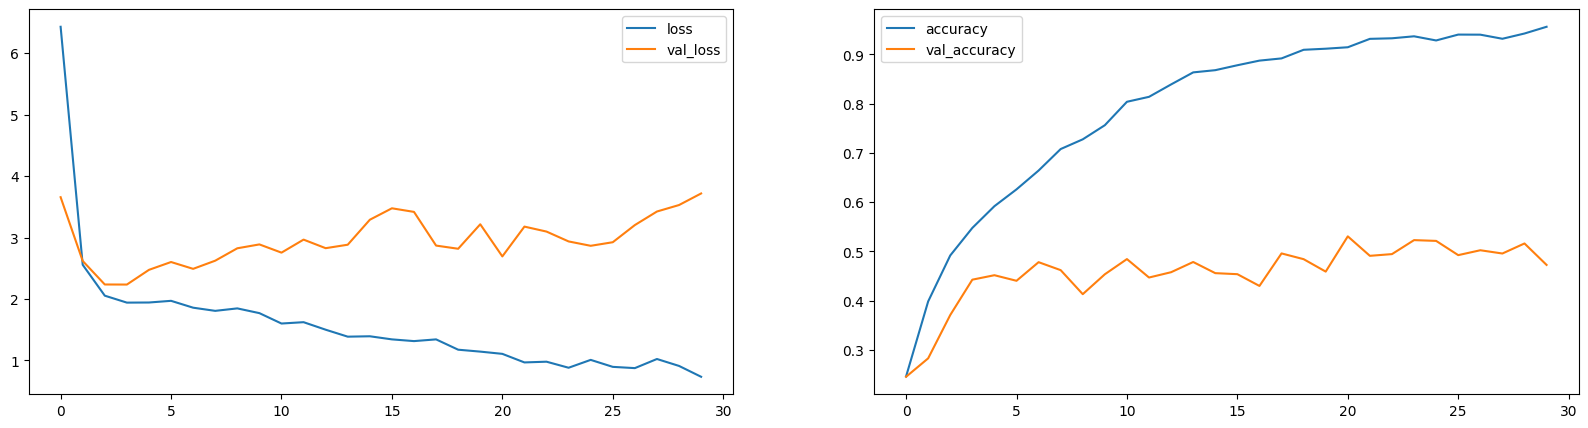

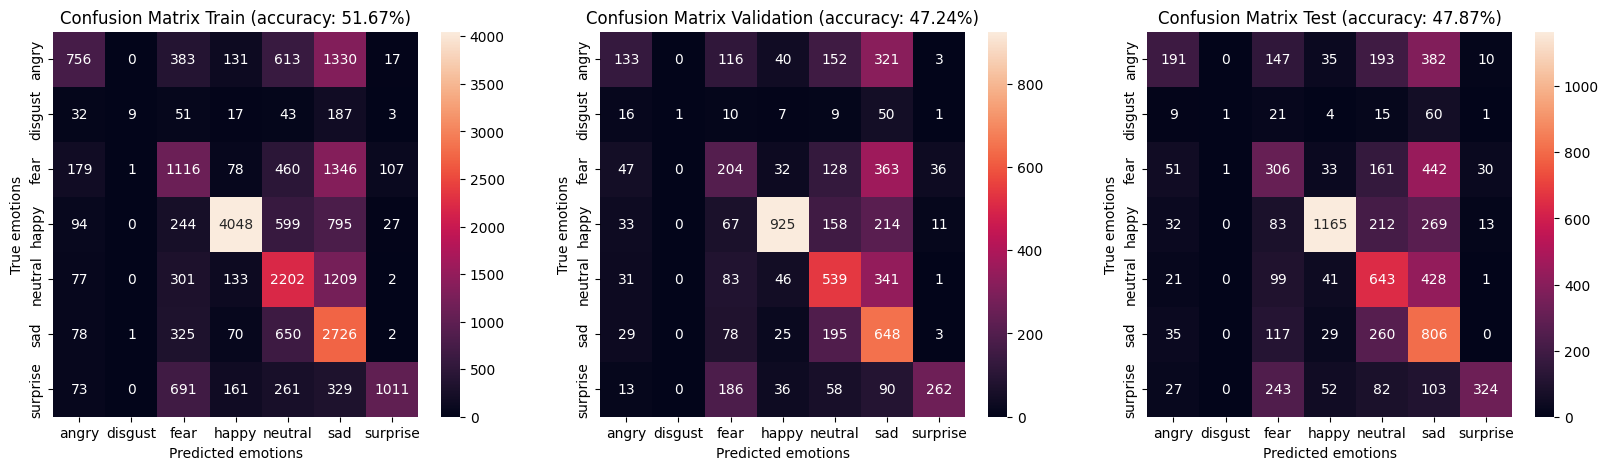

In [21]:
evaluate(model,history2,ds_train,ds_val,ds_test,y_train,y_val,y_test)

<a id="data_augmentation"></a>

# Data augmentation

---

In [22]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=(-0.2,0,2))
    ])
    ds_train_augmented = ds_train.map(
        lambda x, y: (data_augmentation(x), y)
    )
    ds_val_augmented = ds_val.map(
        lambda x, y: (data_augmentation(x), y)
    )

In [23]:
# history = model.fit(
#     ds_train_augmented,
#     validation_data=ds_val_augmented,
#     epochs=30,
# )
# model.save('models/my_model_custom_augmented.h5')
# with open('models/history_custom_augmented.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [42]:
model = load_model('models/my_model_custom_augmented.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom_augmented.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
  1/180 [..............................] - ETA: 40s

2023-03-27 22:29:58.823470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 13s 69ms/step
Calculating validation results:
45/45 [==============================] - 3s 70ms/step
Calculating test results:
57/57 [==============================] - 4s 71ms/step


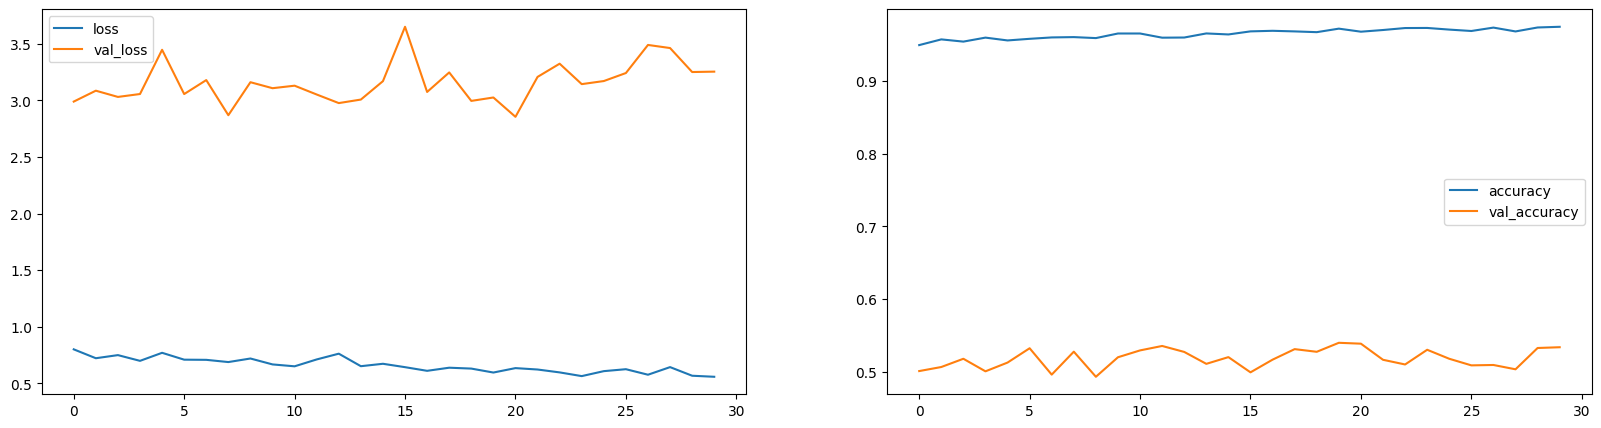

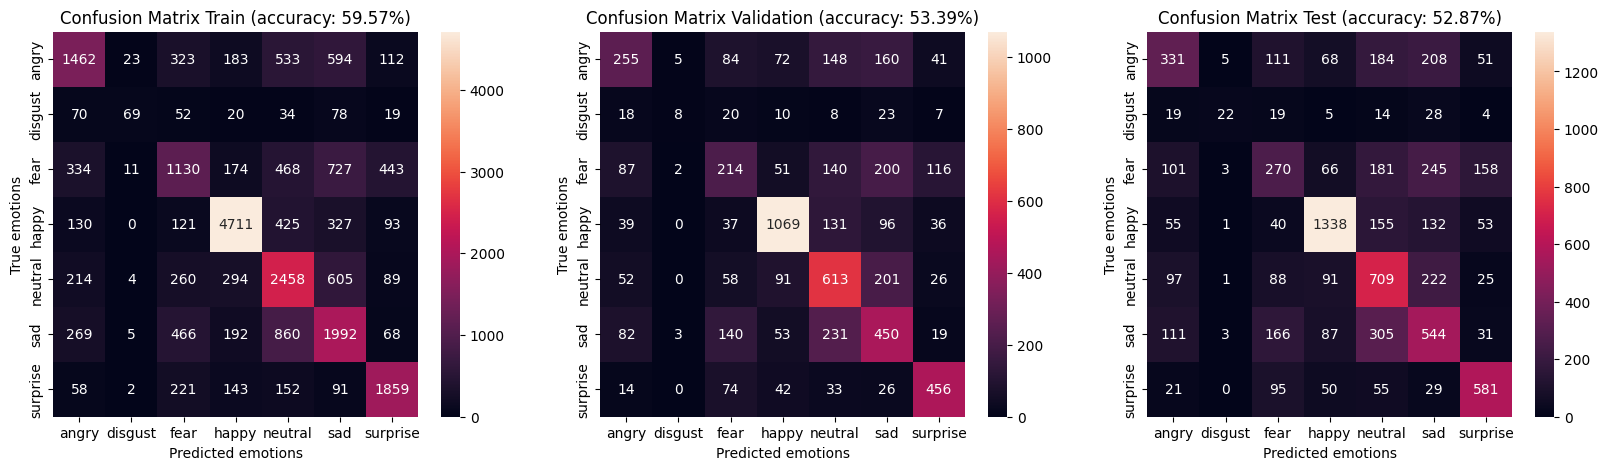

In [25]:
evaluate(model,history2,ds_train_augmented,ds_val_augmented,ds_test,y_train,y_val,y_test)

<a id="grid_search"></a>

# Grid Search

---

In [66]:
X_train = getNumpyArray(ds_train_augmented)
y_train = getLabels(ds_train_augmented)
X_val = getNumpyArray(ds_val_augmented)
y_val = getLabels(ds_val_augmented)
X = np.vstack((X_train,X_val))
y = np.concatenate((y_train,y_val))

scikit_model = KerasClassifier(model=createModel,batch_size=128, epochs=10)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer__learning_rate=learn_rate)
grid = GridSearchCV(estimator=scikit_model, param_grid=param_grid, n_jobs=-1,cv=3)
grid_result = grid.fit(X,y)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-27 23:38:08.960391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 23:38:08.960628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-27 23:38:08.967938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 23:38:08.968072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10


2023-03-27 23:38:16.792638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.821245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.821378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.856526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.883565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.894105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 23:38:16.897836: I tensorflow/core/grappler/optimizers/cust

150/150 [==============================] - 261s 2s/step - loss: 6.8586 - accuracy: 0.2470
Epoch 2/10
150/150 [==============================] - 272s 2s/step - loss: 6.8916 - accuracy: 0.2354
Epoch 2/10
150/150 [==============================] - 295s 2s/step - loss: 6.8586 - accuracy: 0.2470
Epoch 2/10
150/150 [==============================] - 311s 2s/step - loss: 6.8916 - accuracy: 0.2354
Epoch 2/10
150/150 [==============================] - 259s 2s/step - loss: 2.8459 - accuracy: 0.3592
Epoch 3/10
110/150 [=====================>........] - ETA: 1:22 - loss: 2.9632 - accuracy: 0.3469

KeyboardInterrupt: 